In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import rlm
from scipy.stats import norm

# Introduction

In this notebook we explore the effectiveness of Variant A and Variant B on Visits and Downloads. This analysis/notebook will follow this format:

1. Getting and cleaning the data.
2. Plotting distribution and finding outliers
3. Analyzing Data using Z-Test and OLS Regression methodology.

In [11]:
# Load dataset
file_path = '/Users/christopherpeng/Downloads/Take Home Assesment/Exercise_1_-_Webpage_Performance.csv'
data = pd.read_csv(file_path)


rows, columns = data.shape
print(f"Number of rows: {rows}")

Number of rows: 84


In [12]:
data.head(10)

,date,variant,metric,value
0,1/1/24,A,visits,"2,115"
1,1/1/24,A,downloads,42
2,1/1/24,B,visits,529
3,1/1/24,B,downloads,13
4,1/2/24,A,visits,"5,406"
5,1/2/24,A,downloads,108
6,1/2/24,B,visits,"1,352"
7,1/2/24,B,downloads,34
8,1/3/24,A,visits,"2,278"
9,1/3/24,A,downloads,46


# Cleaning Data
Here we start cleaning the data in the value column and removing commas and whitespace and removing any NaN values

We then plot out the distributions of each value for downloads and visits to find outliers

Rows with non-numeric 'value':
       date variant  metric   value
0    1/1/24       A  visits   2,115
4    1/2/24       A  visits   5,406
6    1/2/24       B  visits   1,352
8    1/3/24       A  visits   2,278
12   1/4/24       A  visits   6,725
14   1/4/24       B  visits   1,681
16   1/5/24       A  visits   8,920
18   1/5/24       B  visits   2,230
20   1/6/24       A  visits  54,122
22   1/6/24       B  visits  27,061
24   1/7/24       A  visits  45,158
26   1/7/24       B  visits  22,579
28   1/8/24       A  visits   1,007
32   1/9/24       A  visits   5,895
34   1/9/24       B  visits   1,474
36  1/10/24       A  visits   8,600
38  1/10/24       B  visits   2,150
40  1/11/24       A  visits   5,715
42  1/11/24       B  visits   1,429
44  1/12/24       A  visits   3,189
48  1/13/24       A  visits  54,944
50  1/13/24       B  visits  27,472
52  1/14/24       A  visits  25,272
54  1/14/24       B  visits  12,636
56  1/15/24       A  visits   9,191
58  1/15/24       B  visits   2,2

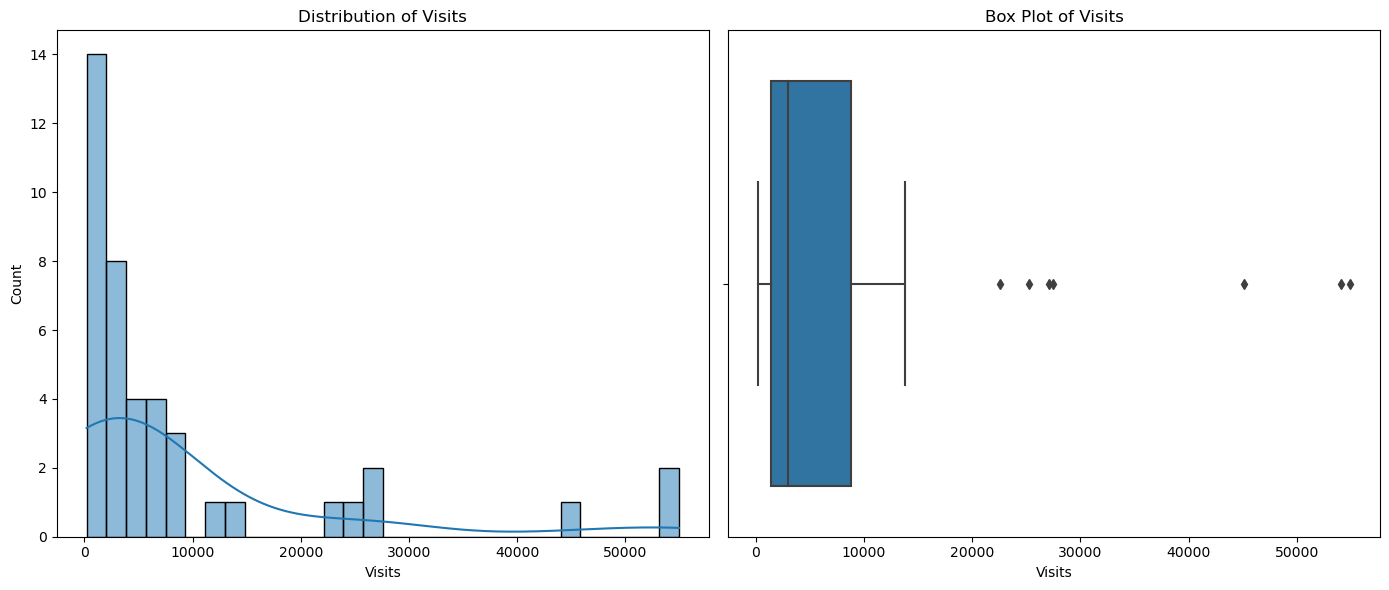

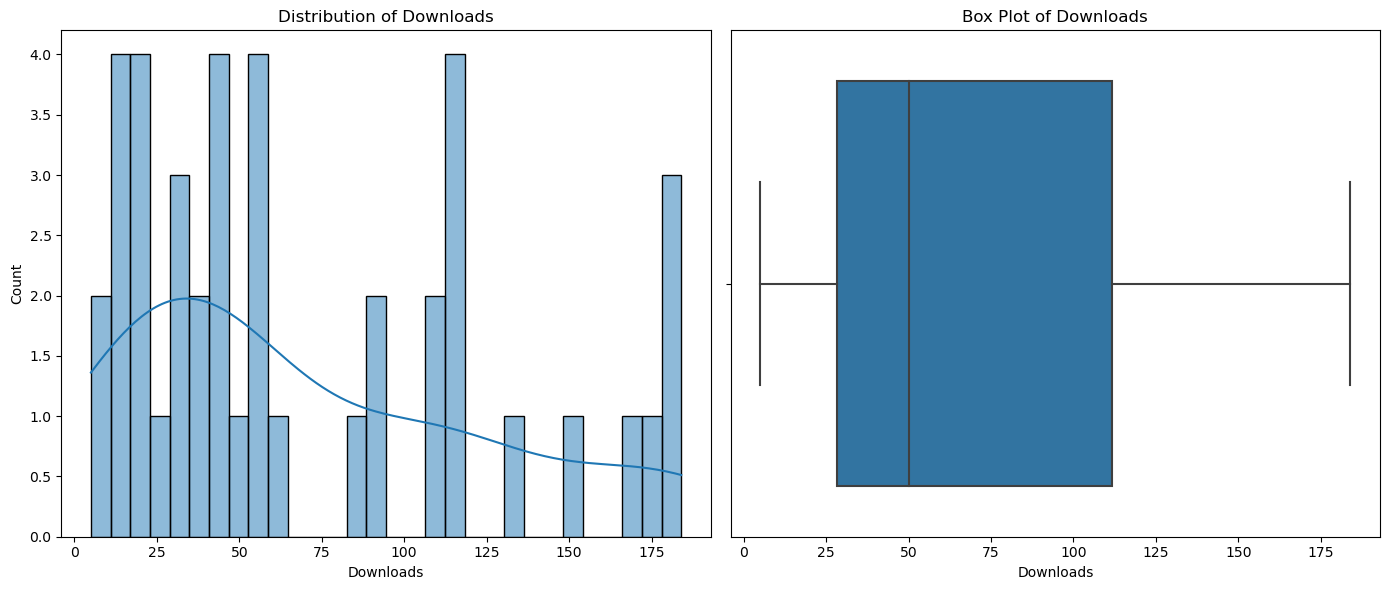

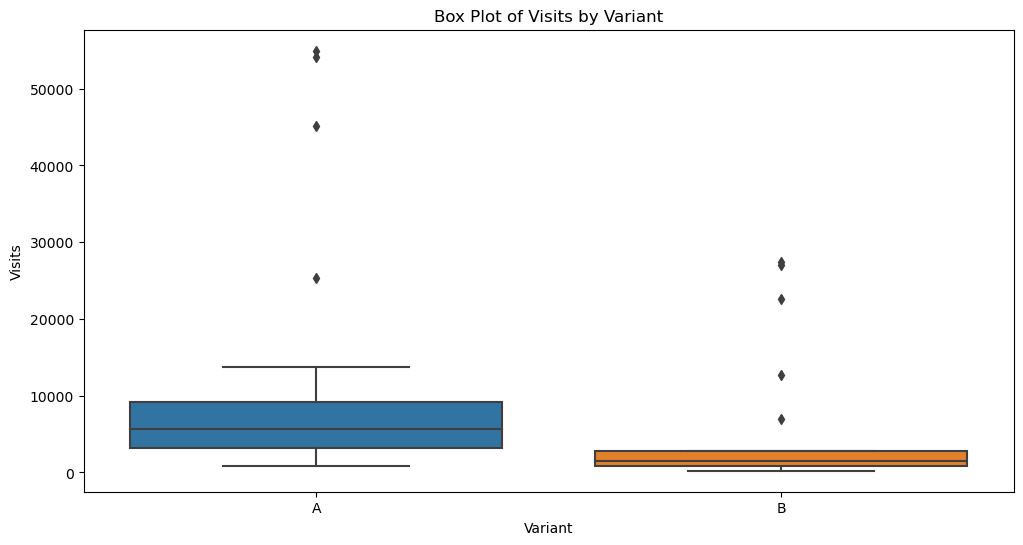

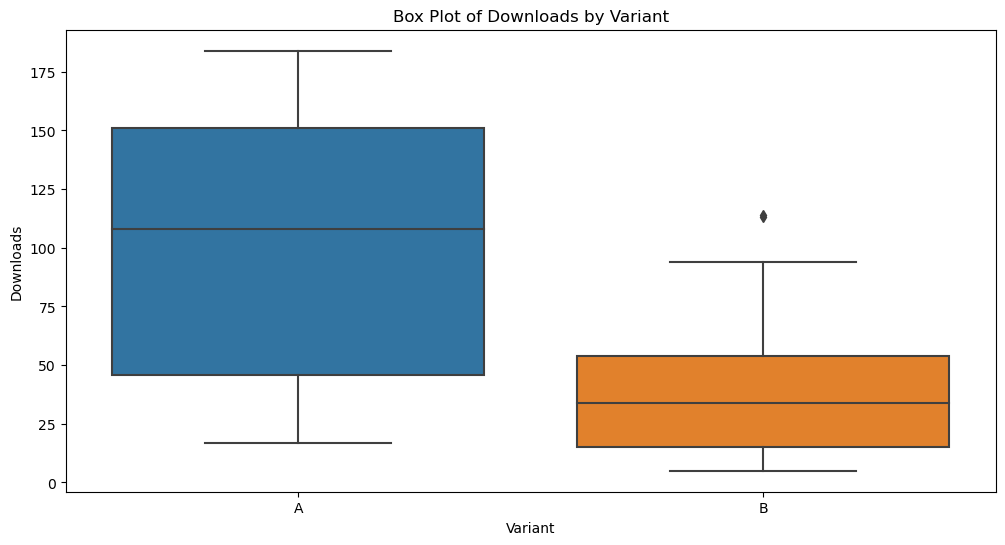

In [13]:
# Strip leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Check the 'value' column for non-numeric entries
non_numeric_rows = data[pd.to_numeric(data['value'], errors='coerce').isna()]
print("Rows with non-numeric 'value':")
print(non_numeric_rows)

# Clean the 'value' column
data['value'] = data['value'].str.replace(',', '')  # Remove commas
data['value'] = data['value'].str.strip()           # Strip whitespace
data['value'].replace({"N/A": None, "null": None, "": None}, inplace=True)  # Replace known non-numeric entries

# Convert 'value' to numeric again
data['value'] = pd.to_numeric(data['value'], errors='coerce')

# Check for NaN values again
print("Number of NaN values in 'value' after cleaning:", data['value'].isnull().sum())

# Split data into visits and downloads
visits_data = data[data['metric'] == 'visits']
downloads_data = data[data['metric'] == 'downloads']

# Histograms and Box Plots for Visits
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(visits_data['value'], bins=30, kde=True)
plt.title('Distribution of Visits')
plt.xlabel('Visits')

plt.subplot(1, 2, 2)
sns.boxplot(x=visits_data['value'])
plt.title('Box Plot of Visits')
plt.xlabel('Visits')

plt.tight_layout()
plt.show()

# Histograms and Box Plots for Downloads
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(downloads_data['value'], bins=30, kde=True)
plt.title('Distribution of Downloads')
plt.xlabel('Downloads')

plt.subplot(1, 2, 2)
sns.boxplot(x=downloads_data['value'])
plt.title('Box Plot of Downloads')
plt.xlabel('Downloads')

plt.tight_layout()
plt.show()

# Box plot for Visits by Variant
plt.figure(figsize=(12, 6))
sns.boxplot(x='variant', y='value', data=visits_data)
plt.title('Box Plot of Visits by Variant')
plt.xlabel('Variant')
plt.ylabel('Visits')
plt.show()

# Box plot for Downloads by Variant
plt.figure(figsize=(12, 6))
sns.boxplot(x='variant', y='value', data=downloads_data)
plt.title('Box Plot of Downloads by Variant')
plt.xlabel('Variant')
plt.ylabel('Downloads')
plt.show()

# Data Analysis
Because there aren't that many outliers and we only have 84 rows of data to work with, we can continue with our analysis to determine the effectiveness of Variant A vs Variant B without removing outliers which will lower the number of data available. We will do so in 2 tests, the Z-Test to determine conversion rate significance between each variant and the OLS Regression Model to determine statistical significance of downloads vs Varaints and visits.


In [14]:
# Function to analyze A/B test variants
def analyze_variants(csv_file):
    try:
        # Load data from the CSV file
        data = pd.read_csv(csv_file)

        # Debug: Check the columns and first few rows
        print("Columns in CSV:", data.columns)
        print("First few rows:\n", data.head())

        # Strip any extra spaces from the column names
        data.columns = data.columns.str.strip()

        # Ensure columns are correctly named
        if 'metric' not in data.columns or 'variant' not in data.columns or 'value' not in data.columns:
            raise KeyError("Required columns ('metric', 'variant', 'value') are not found in the CSV file.")

        # Clean the 'value' column by removing any extra whitespace and converting to numeric
        data['value'] = data['value'].astype(str).str.replace(' ', '').str.replace(',', '')  # Remove spaces and commas
        data['value'] = pd.to_numeric(data['value'], errors='coerce')

        # Check for NaN values in the 'value' column after conversion
        if data['value'].isnull().any():
            print("Warning: Some values in the 'value' column could not be converted to numbers and are set to NaN.")

        # Filter data for each variant and metric
        visits_a = data[(data['variant'] == 'A') & (data['metric'] == 'visits')]
        visits_b = data[(data['variant'] == 'B') & (data['metric'] == 'visits')]
        
        downloads_a = data[(data['variant'] == 'A') & (data['metric'] == 'downloads')]
        downloads_b = data[(data['variant'] == 'B') & (data['metric'] == 'downloads')]

        # Calculate totals, means, and medians for visits
        total_visits_a = visits_a['value'].sum()
        total_visits_b = visits_b['value'].sum()
        
        mean_visits_a = visits_a['value'].mean()
        mean_visits_b = visits_b['value'].mean()
        
        median_visits_a = visits_a['value'].median()
        median_visits_b = visits_b['value'].median()

        # Calculate totals, means, and medians for downloads
        total_downloads_a = downloads_a['value'].sum()
        total_downloads_b = downloads_b['value'].sum()
        
        mean_downloads_a = downloads_a['value'].mean()
        mean_downloads_b = downloads_b['value'].mean()
        
        median_downloads_a = downloads_a['value'].median()
        median_downloads_b = downloads_b['value'].median()

        # Calculate conversion rates for each variant
        conv_rate_a = total_downloads_a / total_visits_a if total_visits_a > 0 else 0
        conv_rate_b = total_downloads_b / total_visits_b if total_visits_b > 0 else 0

        # Display results
        print("Visits:")
        print(f"  Total Visits A: {total_visits_a}, Mean Visits A: {mean_visits_a:.2f}, Median Visits A: {median_visits_a:.2f}")
        print(f"  Total Visits B: {total_visits_b}, Mean Visits B: {mean_visits_b:.2f}, Median Visits B: {median_visits_b:.2f}")
        
        print("\nDownloads:")
        print(f"  Total Downloads A: {total_downloads_a}, Mean Downloads A: {mean_downloads_a:.2f}, Median Downloads A: {median_downloads_a:.2f}")
        print(f"  Total Downloads B: {total_downloads_b}, Mean Downloads B: {mean_downloads_b:.2f}, Median Downloads B: {median_downloads_b:.2f}")

        print("\nConversion Rates:")
        print(f"  Conversion Rate A: {conv_rate_a:.4f}")
        print(f"  Conversion Rate B: {conv_rate_b:.4f}")

        # Perform two-proportion z-test
        def z_test(p1, p2, n1, n2):
            p_pool = (p1 * n1 + p2 * n2) / (n1 + n2)  # Pooled proportion
            se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))  # Standard error
            z = (p1 - p2) / se  # Z-score
            p_value = 2 * (1 - norm.cdf(abs(z)))  # Two-tailed p-value
            return z, p_value

        z_score, p_value = z_test(conv_rate_a, conv_rate_b, total_visits_a, total_visits_b)

        print(f"\nZ-score: {z_score:.4f}, P-value: {p_value:.4f}")

        # Determine statistical significance
        alpha = 0.05  # Significance level
        if p_value < alpha:
            print("The difference is statistically significant. We recommend Variant A.")
        else:
            print("The difference is not statistically significant. No strong recommendation can be made.")

    except KeyError as e:
        print(f"KeyError: {e}. Please check the CSV file for correct column names.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage with your file path
analyze_variants('/Users/christopherpeng/Downloads/Take Home Assesment/Exercise_1_-_Webpage_Performance.csv')


Columns in CSV: Index(['date', 'variant', 'metric ', ' value '], dtype='object')
First few rows:
      date variant    metric   value 
0  1/1/24       A     visits   2,115
1  1/1/24       A  downloads      42
2  1/1/24       B     visits     529
3  1/1/24       B  downloads      13
4  1/2/24       A     visits   5,406
Visits:
  Total Visits A: 271060, Mean Visits A: 12907.62, Median Visits A: 5715.00
  Total Visits B: 117485, Mean Visits B: 5594.52, Median Visits B: 1474.00

Downloads:
  Total Downloads A: 2107, Mean Downloads A: 100.33, Median Downloads A: 108.00
  Total Downloads B: 866, Mean Downloads B: 41.24, Median Downloads B: 34.00

Conversion Rates:
  Conversion Rate A: 0.0078
  Conversion Rate B: 0.0074

Z-score: 1.3209, P-value: 0.1865
The difference is not statistically significant. No strong recommendation can be made.


# Some key observations:

1. Visits: Variant A has a much higher total number of visits compared to variant B, with A showing both a higher mean and median visits.
2. Downloads: While the total number of downloads and mean downloads are higher for variant A, the difference between conversion rates (A: 0.0078 vs. B: 0.0074) is quite small.

Conclusion: Given that the p-value exceeds the common threshold for significance, we cannot confidently conclude that one variant is performing better than the other in terms of conversion rates. No strong recommendation can be made based on this data.

In [16]:
# Function to analyze A/B test variants
def analyze_variants(csv_file):
    try:
        # Load data from the CSV file
        data = pd.read_csv(csv_file)

        # Debug: Check the columns and first few rows
        print("Columns in CSV:", data.columns)
        print("First few rows:\n", data.head())

        # Strip any extra spaces from the column names
        data.columns = data.columns.str.strip()

        # Clean the 'value' column by removing any extra whitespace and converting to numeric
        data['value'] = data['value'].astype(str).str.replace(' ', '').str.replace(',', '')  # Remove spaces and commas
        data['value'] = pd.to_numeric(data['value'], errors='coerce')

        # Check for NaN values in the 'value' column after conversion
        if data['value'].isnull().any():
            print("Warning: Some values in the 'value' column could not be converted to numbers and are set to NaN.")

        # Create dummy variables for the variant column
        data['variant'] = data['variant'].astype('category')
        data = pd.get_dummies(data, columns=['variant'], drop_first=True)  # drop_first=True to avoid multicollinearity

        # Filter data for downloads metric
        downloads_data = data[data['metric'] == 'downloads']

        # Prepare the independent and dependent variables
        X = downloads_data[['value', 'variant_B']]  # Using 'value' (visits) and dummy for variant B
        y = downloads_data['value']  # Dependent variable (downloads)

        # Add a constant to the model (for the intercept)
        X = sm.add_constant(X)

        # Fit the OLS model
        model = sm.OLS(y, X).fit()

        # Print the regression results
        print(model.summary())

        # The rest of the analysis as before
        # Calculate totals, means, and medians for visits
        visits_a = data[(data['variant_A'] == 1) & (data['metric'] == 'visits')]
        visits_b = data[(data['variant_B'] == 1) & (data['metric'] == 'visits')]
        
        total_visits_a = visits_a['value'].sum()
        total_visits_b = visits_b['value'].sum()

        # Other calculations (mean, median, conversion rates, etc.)...

    except KeyError as e:
        print(f"KeyError: {e}. Please check the CSV file for correct column names.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage with your file path
analyze_variants('/Users/christopherpeng/Downloads/Take Home Assesment/Exercise_1_-_Webpage_Performance.csv')


Columns in CSV: Index(['date', 'variant', 'metric ', ' value '], dtype='object')
First few rows:
      date variant    metric   value 
0  1/1/24       A     visits   2,115
1  1/1/24       A  downloads      42
2  1/1/24       B     visits     529
3  1/1/24       B  downloads      13
4  1/2/24       A     visits   5,406
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.074e+31
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:40:54   Log-Likelihood:                 1224.1
No. Observations:                  42   AIC:                            -2442.
Df Residuals:                      39   BIC:                            -2437.
Df Model:                           2           

# OLS Result Interpretation

1. Downloads (Constant): This value is extremely close to zero, suggesting that when visits are zero, the downloads are effectively negligible. The intercept is not statistically significant (p-value = 0.439), indicating that it doesn't contribute much to the model.
2. Value (Visits): This coefficient suggests a perfect linear relationship between visits and downloads. For each additional visit, the number of downloads increases by 1. p-value: 0.000, which means this coefficient is highly statistically significant. This strong relationship likely dominates the model.
3. This coefficient is also very close to zero, indicating that the presence of variant B does not meaningfully impact the relationship between visits and downloads. p-value: 0.672, suggesting that this variable is not statistically significant and does not contribute much to explaining variations in downloads.

# OLS Summary

The most important takeaway is the perfect relationship between visits and downloads, with each visit leading to exactly one download, as indicated by the coefficient of 1.0000. This suggests the model is likely oversimplified or might reflect an identity transformation between visits and downloads.

Both the intercept and variant B show very small coefficients and high p-values, meaning they do not provide meaningful insights or have significant effects on the outcome.

The model seems to be driven almost entirely by the number of visits, and other factors like the variant do not significantly contribute to predicting downloads.

# Conclusion:

1. Both the OLS regression and z-test results show that variant B has no significant effect on performance (in terms of downloads or conversion rates).
2. The number of visits is the primary factor driving downloads, while the conversion rates are nearly identical across the two variants.
3. These analyses suggest that focusing on increasing visits may be more impactful than focusing on variant differentiation for driving downloads.

